# Estimating the correlation length 

* A central parameter for the `DIVAnd` analysis is the correlation length.
* It determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf

# Data reading

The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the World Ocean Database for the Provençal Basin (Mediterranean Sea). The profiles were not interpolated vertically. It is based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. 

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* Load the data file if it is not already present.

In [21]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else
    @info("Data file $filename already downloaded")
end

┌ Info: Data file ../data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[21]:7


Load the data and print basic information about it that can be used for quality check.

In [9]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


For this example we select only the first month (January)

In [10]:
sel = (Dates.month.(obstime) .== 1)
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500];

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [88]:
Random.seed!(1234);
@time lenxy,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m);

┌ Info: Data points at z=0.0: 18551, horz. correlation length: 24022.046975604026 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=10.0: 21948, horz. correlation length: 22587.30398234348 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=100.0: 30934, horz. correlation length: 12607.306399076084 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=200.0: 26778, horz. correlation length: 9835.30374183339 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=300.0: 17596, horz. correlation length: 4807.849360662597 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Warning: Too few data. Will use guesses (np = 4, RLz = 9872.821972635053, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Data points at z=400.0: 14144, horz. corre

 27.762276 seconds (499.90 M allocations: 14.910 GiB, 7.21% gc time)


┌ Info: Data points at z=1500.0: 5162, horz. correlation length: 2148.116294105566 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Smoothed horz. correlation length at z=0.0: 25699.76049876911
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=10.0: 28614.66685369602
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=100.0: 33889.93322120356
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=200.0: 40393.235002903326
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=300.0: 46546.60002173506
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=400.0: 50768.41949246047
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed h

Information about the fitting:


In [89]:
infoxy[:fitinfos][1]

Dict{Symbol,Any} with 8 entries:
  :sn          => 0.25371
  :rqual       => 0.867339
  :fitcovar    => [NaN, 0.0146972, 0.0142847, 0.0137565, 0.0131602, 0.0125259, …
  :meandist    => 1.81573e5
  :covar       => [0.0197843, 0.0166422, 0.0135851, 0.0120818, 0.0110508, 0.009…
  :range       => 2:35
  :distx       => 0.0:2269.65674372676:708132.9040427491
  :covarweight => [4.46508e11, 4.56482e11, 4.94537e11, 4.47725e11, 4.4647e11, 4…

Extract the information for the level `k = 1`:
* `covar`: the empirical covariance
* `fitcovar`: the fitted empirical covariance
* `distx`: distance
* `range`: part of `covar` used for the fitting
* `rqual`: the quality for the fit (1: excellent, 0: poor)

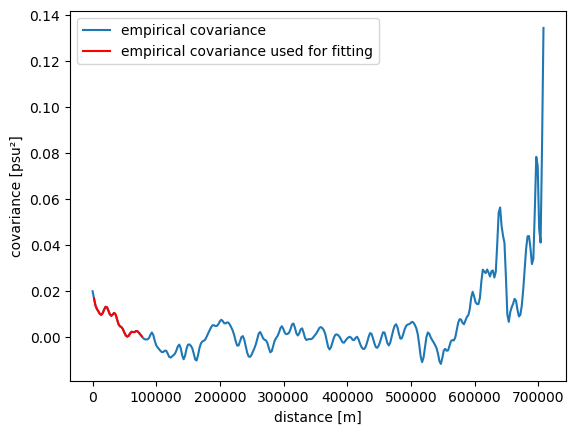

In [90]:
k = 1
covar = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx = infoxy[:fitinfos][k][:distx]
range = infoxy[:fitinfos][k][:range]
rqual = infoxy[:fitinfos][k][:rqual]

plot(distx,covar,label="empirical covariance")
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

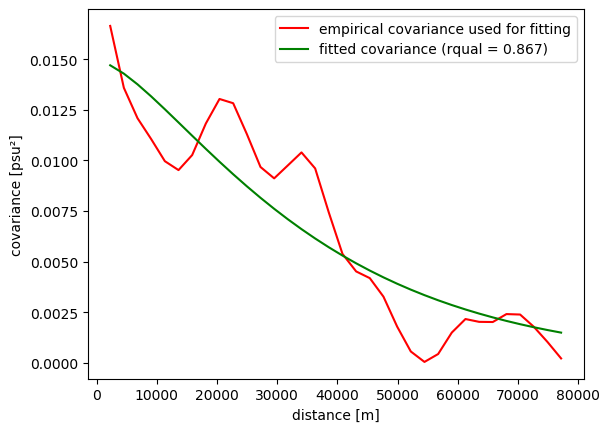

In [91]:
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
plot(distx[range],fitcovar[range],"g",label="fitted covariance (rqual = $(@sprintf("%4.3f",rqual)))")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

Try different values of k (the level index) and rerun the previous two cells. Note that at some level the fit was quite poor. Additional filtering (vertically) is done to smooth the horizontal correlation length.


Make a plot of the horizontal correlation length with respect to the depth. 

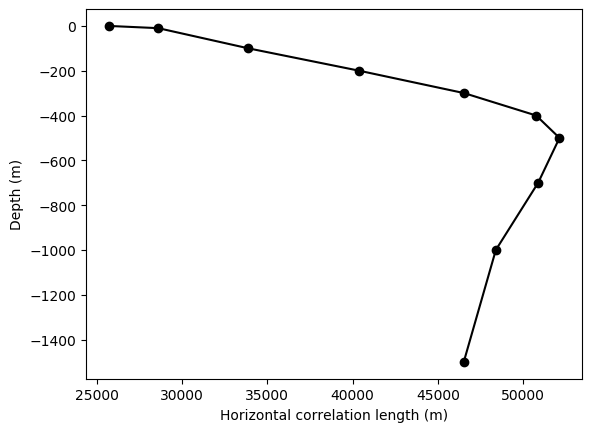

In [92]:
plot(lenxy,-z, "ko-")
xlabel("Horizontal correlation length (m)")
ylabel("Depth (m)");

It is useful to limit the acceptable range of the correlation length by providing a function `limitfun` with the argument depth `z` and estimated correlation length `len`. It the returns the adjusted correlation length. This adjustememt is done before the filtering.

┌ Info: Data points at z=0.0: 18551, horz. correlation length: 24022.046975604026 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=10.0: 21948, horz. correlation length: 22587.30398234348 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=100.0: 30934, horz. correlation length: 12607.306399076084 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=200.0: 26778, horz. correlation length: 9835.30374183339 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Data points at z=300.0: 17596, horz. correlation length: 4807.849360662597 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Warning: Too few data. Will use guesses (np = 4, RLz = 9872.821972635053, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Data points at z=400.0: 14144, horz. corre

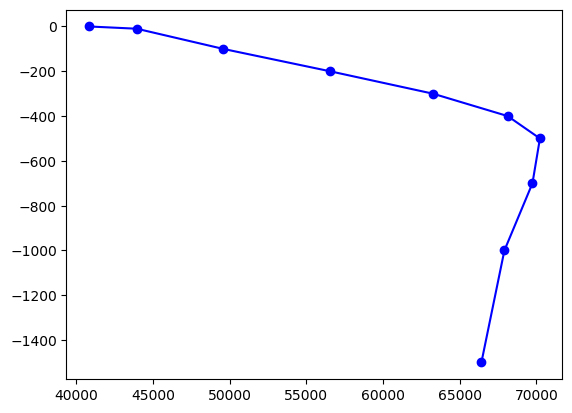

 27.467140 seconds (500.37 M allocations: 14.933 GiB, 7.34% gc time)


┌ Info: Data points at z=1500.0: 5162, horz. correlation length: 2148.116294105566 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1068
┌ Info: Smoothed horz. correlation length at z=0.0: 40832.07178038798
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=10.0: 43945.33509402009
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=100.0: 49578.0050493489
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=200.0: 56550.03199535424
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=300.0: 63260.478551504246
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed horz. correlation length at z=400.0: 68131.81677178868
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1093
┌ Info: Smoothed ho

In [97]:
@time lenxy2,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, limitfun = (z,len) -> max(len,30e3));
plot(lenxy2,-z, "bo-");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [94]:
Random.seed!(1234);
@time lenz,infoz = fitvertlen(x,v,z);

┌ Info: Vert. correlation length at z=0.0: 46.55059200000001
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1157
┌ Info: Vert. correlation length at z=10.0: 46.54409600000001
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1157
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 178.22644592285155, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Vert. correlation length at z=100.0: 178.22644592285155
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1157
┌ Info: Vert. correlation length at z=200.0: 90.87321600000001
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1157
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 181.6, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Vert. correlation length at z=300.0: 181.6
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1157
┌ Info: Vert. correlation length at z=400.0: 162.22819310742187
└ @ DIVAnd /home/abarth/projects/Juli

  3.864995 seconds (35.27 M allocations: 3.099 GiB, 12.29% gc time)


Make a plot

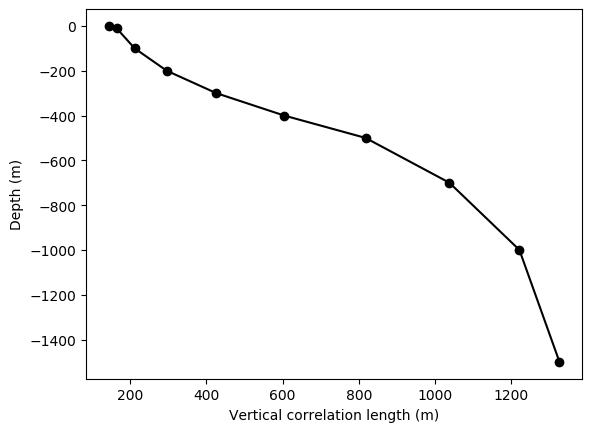

In [95]:
plot(lenz,-z, "ko-")
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");